<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

## Подготовка данных

### Импорт библитек

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
import pandas_profiling
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from scipy import stats as st

### Откройте файлы и изучите их.

In [2]:
data_train = pd.read_csv("https://code.s3.yandex.net/datasets/gold_recovery_train_new.csv", index_col='date', parse_dates=True)
data_test = pd.read_csv("https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv", index_col='date', parse_dates=True)
data_full = pd.read_csv("https://code.s3.yandex.net/datasets/gold_recovery_full_new.csv", index_col='date', parse_dates=True)

In [3]:
# разбиваем названия столбцов фичей на части
splits = pd.DataFrame([*data_full.columns.str.split(".")], 
                      columns=["stage","param_type","param_name"])

# выводим уникальные названия параметра
splits["param_name"].sort_values().unique() #рассмотрим наименование коллнок в датасете

array(['au_pb_ratio', 'concentrate_ag', 'concentrate_au',
       'concentrate_pb', 'concentrate_sol', 'depressant', 'feed_ag',
       'feed_au', 'feed_pb', 'feed_rate', 'feed_size', 'feed_sol',
       'floatbank10_a_air', 'floatbank10_a_level', 'floatbank10_b_air',
       'floatbank10_b_level', 'floatbank10_c_air', 'floatbank10_c_level',
       'floatbank10_d_air', 'floatbank10_d_level', 'floatbank10_e_air',
       'floatbank10_e_level', 'floatbank10_f_air', 'floatbank10_f_level',
       'floatbank10_sulfate', 'floatbank10_sulfate_to_au_feed',
       'floatbank10_xanthate', 'floatbank11_sulfate',
       'floatbank11_sulfate_to_au_feed', 'floatbank11_xanthate',
       'floatbank2_a_air', 'floatbank2_a_level', 'floatbank2_b_air',
       'floatbank2_b_level', 'floatbank3_a_air', 'floatbank3_a_level',
       'floatbank3_b_air', 'floatbank3_b_level', 'floatbank4_a_air',
       'floatbank4_a_level', 'floatbank4_b_air', 'floatbank4_b_level',
       'floatbank5_a_air', 'floatbank5_a_level', 'f

In [4]:
data_full.columns

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state

**Технологический процесс**  
Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.

![Image](https://pictures.s3.yandex.net/resources/viruchka_1576238830.jpg)

Исходя из данной схемы, нам необходимо будет разделить обучающую выборку на два компонента - это флотации и два этапа очистки


**Опишем каждую стадию:**

*1. Флотация*  
Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.  
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости). 

*2. Очистка*   
Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.  
**Описание данных**  
Технологический процесс  
Rougher feed — исходное сырье  
Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant  
Xanthate — ксантогенат (промотер, или активатор флотации);  
Sulphate — сульфат (на данном производстве сульфид натрия);  
Depressant — депрессант (силикат натрия).  
Rougher process (англ. «грубый процесс») — флотация  
Rougher tails — отвальные хвосты  
Float banks — флотационная установка  
Cleaner process — очистка  
Rougher Au — черновой концентрат золота  
Final Au — финальный концентрат золота  
Параметры этапов  
air amount — объём воздуха  
fluid levels — уровень жидкости  
feed size — размер гранул сырья  
feed rate — скорость подачи

**Наименование признаков**  
*Наименование признаков должно быть такое:*  
[этап].[тип_параметра].[название_параметра]  
Пример: rougher.input.feed_ag  
Возможные значения для блока [этап]:  
rougher — флотация  
primary_cleaner — первичная очистка  
secondary_cleaner — вторичная очистка  
final — финальные характеристики  
Возможные значения для блока [тип_параметра]:  
input — параметры сырья  
output — параметры продукта  
state — параметры, характеризующие текущее состояние этапа  
calculation — расчётные характеристики  
**Нужно спрогнозировать сразу две величины:**  
эффективность обогащения чернового концентрата  
***rougher.output.recovery;***  
эффективность обогащения финального концентрата  
***final.output.recovery.***  


In [5]:
pd.set_option("display.max_columns", 9)
data_full.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,...,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,...,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,...,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,...,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,...,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,...,7.894242,-500.356035,13.996647,-601.496691


In [6]:
data_train.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,...,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,...,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,...,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,...,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,...,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,...,7.894242,-500.356035,13.996647,-601.496691


In [7]:
data_test.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,...,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,...,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,...,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,...,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,...,4.931400,-499.963623,24.948919,-498.709987
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,...,4.957674,-500.360026,25.003331,-500.856333


In [8]:
print('Данные для обучающей выборке доступны за период от', 
      pd.to_datetime(data_train.index.min()), 'до', pd.to_datetime(data_train.index.max()))

Данные для обучающей выборке доступны за период от 2016-01-15 00:00:00 до 2018-08-18 10:59:59


In [9]:
print('Данные для тестовой выборке доступны за период от', 
      pd.to_datetime(data_test.index.min()), 'до', pd.to_datetime(data_test.index.max()))

Данные для тестовой выборке доступны за период от 2016-09-01 00:59:59 до 2017-12-31 23:59:59


In [10]:
print('Данные для полной выборке доступны за период от', 
      pd.to_datetime(data_full.index.min()), 'до', pd.to_datetime(data_full.index.max()))

Данные для полной выборке доступны за период от 2016-01-15 00:00:00 до 2018-08-18 10:59:59


Получается тестовый и обучающая выборка оба отрезка находяться в полной выборке

In [11]:
def samples(data, x, y):
    return print('Количество образцов обучающей выборки:', len(x),'\n',
                 'Количество образцов тестовой выборки:', len(y),'\n',
                 'Сумма выборок:', len(x) + len(y),'\n',
                 'Количество образцов подготовленной выборки (контрольная сумма):', len(data),  
                 'Доля тестовой выборки:{:.2%}'.format((len(y)/len(data))),  
                 'Доля тренировочной выборки:{:.2%}'.format((len(x)/len(data))))

In [12]:
samples(data_full, data_train, data_test)

Количество образцов обучающей выборки: 14149 
 Количество образцов тестовой выборки: 5290 
 Сумма выборок: 19439 
 Количество образцов подготовленной выборки (контрольная сумма): 19439 Доля тестовой выборки:27.21% Доля тренировочной выборки:72.79%


Доля тестовой выборке 27,21%, требуется минимум 20%. Можно работать.

### Проверена формула вычисления эффективности обогащения

**Расчёт эффективности**  
Вам нужно смоделировать процесс восстановления золота из золотосодержащей руды.   
Эффективность обогащения рассчитывается по формуле  

${\large Recovery=\dfrac{C(F-T)}{F(C-T)}100\%}$   
где:
C — доля золота в концентрате после флотации/очистки;  
F — доля золота в сырье/концентрате до флотации/очистки;  
T — доля золота в отвальных хвостах после флотации/очистки.  
Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.  

In [13]:
def recovery(data, C, F, T):
    recovery = (((C * (F-T))) / (F * (C-T)))*100
    return recovery



In [14]:
C = data_train['rougher.output.concentrate_au']
F = data_train['rougher.input.feed_au']
T = data_train['rougher.output.tail_au']
recovery(data_train, C, F, T)


date
2016-01-15 00:00:00    87.107763
2016-01-15 01:00:00    86.843261
2016-01-15 02:00:00    86.842308
2016-01-15 03:00:00    87.226430
2016-01-15 04:00:00    86.688794
                         ...    
2018-08-18 06:59:59    89.574376
2018-08-18 07:59:59    87.724007
2018-08-18 08:59:59    88.890579
2018-08-18 09:59:59    89.858126
2018-08-18 10:59:59    89.514960
Length: 14149, dtype: float64

In [15]:
MAE = mean_absolute_error(data_train['rougher.output.recovery'], recovery(data_train, C, F, T))
print('Средняя абсолютная ошибка: {:.17f}'.format(MAE))

Средняя абсолютная ошибка: 0.00000000000000974


Средняя абсолютная ошибка стремиться к нулю - формула для вычисления эффективности обогощении верна.

### Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

In [16]:
data_train.shape, data_test.shape #тестовая выборка содержит меньше параметров чем обучающая

((14149, 86), (5290, 52))

In [17]:
print('Количество признаков, отсутствующих в тестовой выборке:' , len(set(data_train) - set(data_test)))
set(data_train.columns) - set(data_test.columns)

Количество признаков, отсутствующих в тестовой выборке: 34


{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Оба целевых признака отсутствуют в тестовой выборке, возьмем их из полной выборке. За индексы возьмем дату со временем

In [18]:
data_test.index

DatetimeIndex(['2016-09-01 00:59:59', '2016-09-01 01:59:59',
               '2016-09-01 02:59:59', '2016-09-01 03:59:59',
               '2016-09-01 04:59:59', '2016-09-01 05:59:59',
               '2016-09-01 06:59:59', '2016-09-01 07:59:59',
               '2016-09-01 08:59:59', '2016-09-01 09:59:59',
               ...
               '2017-12-31 14:59:59', '2017-12-31 15:59:59',
               '2017-12-31 16:59:59', '2017-12-31 17:59:59',
               '2017-12-31 18:59:59', '2017-12-31 19:59:59',
               '2017-12-31 20:59:59', '2017-12-31 21:59:59',
               '2017-12-31 22:59:59', '2017-12-31 23:59:59'],
              dtype='datetime64[ns]', name='date', length=5290, freq=None)

In [19]:
data_full.index

DatetimeIndex(['2016-01-15 00:00:00', '2016-01-15 01:00:00',
               '2016-01-15 02:00:00', '2016-01-15 03:00:00',
               '2016-01-15 04:00:00', '2016-01-15 05:00:00',
               '2016-01-15 06:00:00', '2016-01-15 07:00:00',
               '2016-01-15 08:00:00', '2016-01-15 09:00:00',
               ...
               '2018-08-18 01:59:59', '2018-08-18 02:59:59',
               '2018-08-18 03:59:59', '2018-08-18 04:59:59',
               '2018-08-18 05:59:59', '2018-08-18 06:59:59',
               '2018-08-18 07:59:59', '2018-08-18 08:59:59',
               '2018-08-18 09:59:59', '2018-08-18 10:59:59'],
              dtype='datetime64[ns]', name='date', length=19439, freq=None)

In [20]:
#добавим в обучающую выборку целевые признаки
targets =['rougher.output.recovery', 'final.output.recovery']

data_test.loc[:, targets ] = data_full[targets]

In [21]:
print('Количество признаков, отсутствующих в тестовой выборке:' , len(set(data_train) - set(data_test)))
set(data_train.columns) - set(data_test.columns)

Количество признаков, отсутствующих в тестовой выборке: 32


{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'secondary_cleane

Целевые признаки добавлены в тестовую выборку из полных данных. Индексом является дата со временемdata_train

<AxesSubplot: >

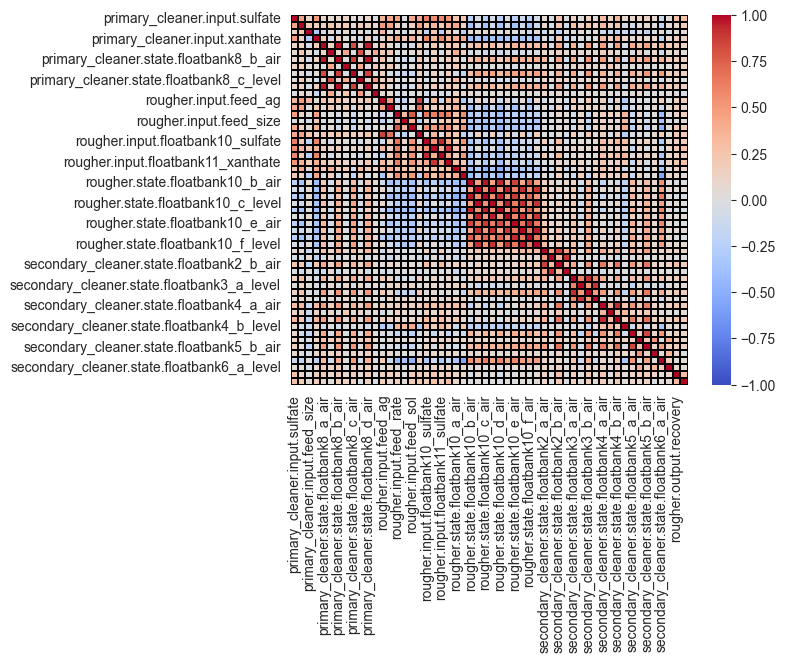

In [22]:
sns.heatmap(data_test.corr(), annot = False, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=0.003, linecolor='black')

Многие праметры связаны между собой, следовательно пока не будем удалять столбцы. Потом это можно будет сделать. когда мы будем уверенны, что удаление параметров не повлияет на модель

### Проведите предобработку данных.

### Посмотрим выбросы

In [23]:
data_train.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
final.output.concentrate_ag,14148.0,5.142034,1.369586,0.0,4.211620,4.994652,5.859540,16.001945
final.output.concentrate_pb,14148.0,10.132960,1.654930,0.0,9.297355,10.297144,11.170603,17.031899
final.output.concentrate_sol,13938.0,9.202849,2.790516,0.0,7.484645,8.845462,10.487508,18.124851
final.output.concentrate_au,14149.0,44.003792,4.905261,0.0,43.276111,44.872436,46.166425,52.756638
final.output.recovery,14149.0,66.518832,10.295402,0.0,62.545817,67.432775,72.346428,100.000000


In [24]:
elements = {'золото': 'au', 'серебро': 'ag', 'свинец': 'pb'}

In [25]:
def boxplot(elem):
    
    cols = ['rougher.input.feed_'+elem, 'rougher.output.concentrate_'+elem, 
            'primary_cleaner.output.concentrate_'+elem, 'final.output.concentrate_'+elem,
           'secondary_cleaner.output.tail_'+elem]
    
    plt.figure(figsize=(15,10))
    sns.boxplot(data=data_train[cols], linewidth=0.42, palette="Set2")
    plt.title('Концентрация металла ' + str(elem).title() + ' на различных этапах очистки', fontsize=15)

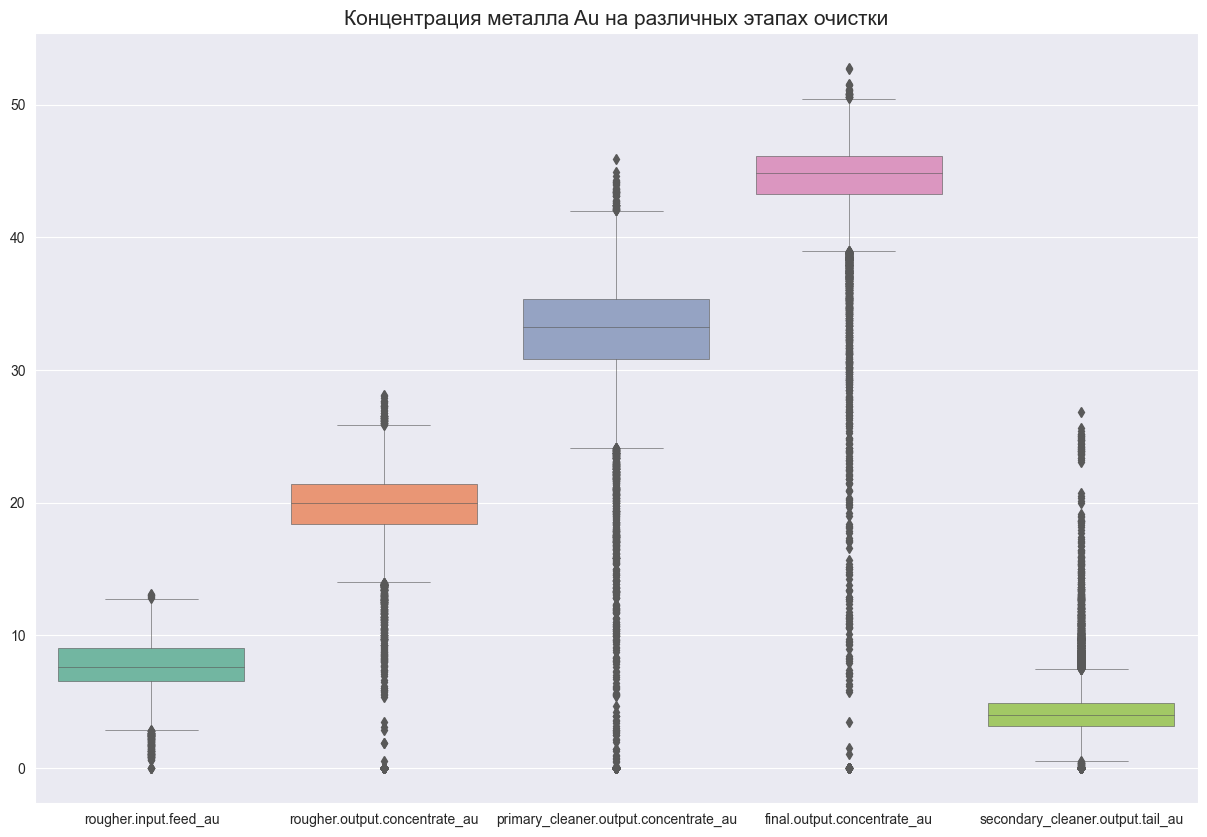

In [26]:
boxplot(elements['золото'])

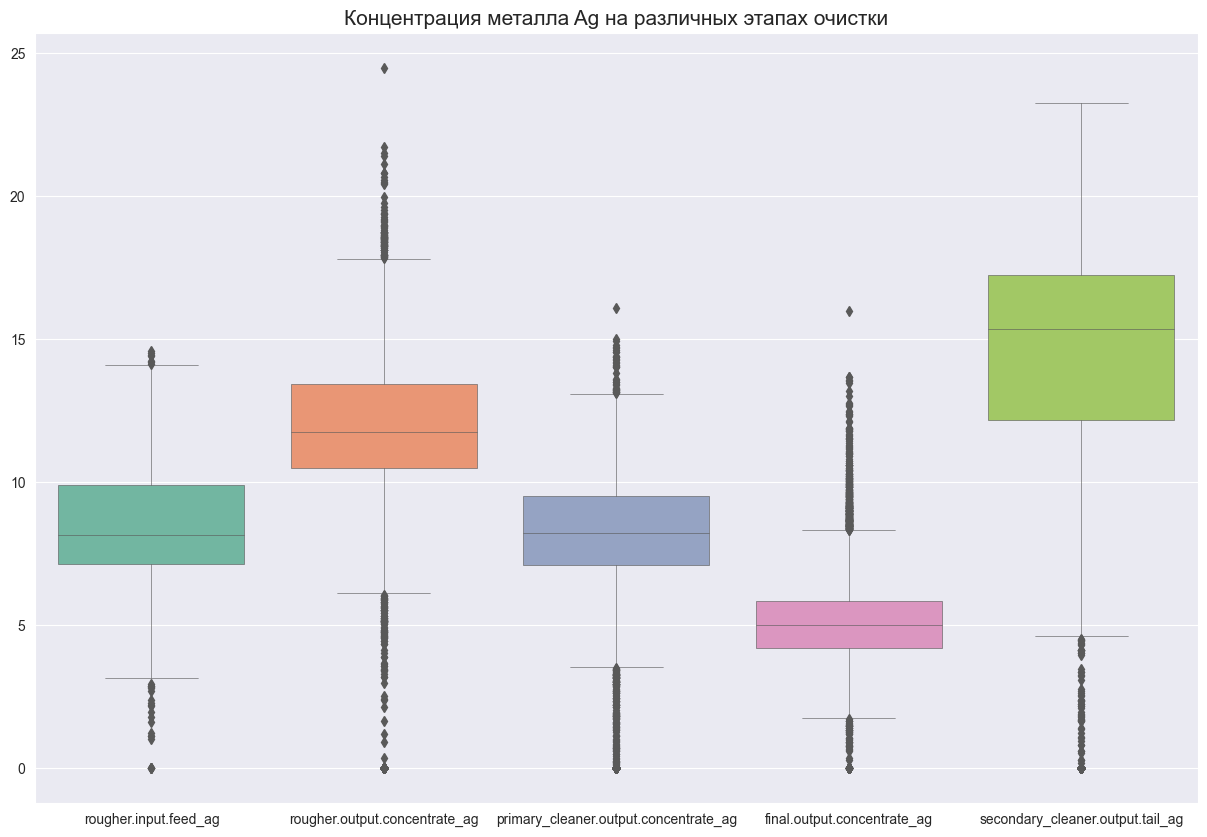

In [27]:
boxplot(elements['серебро'])

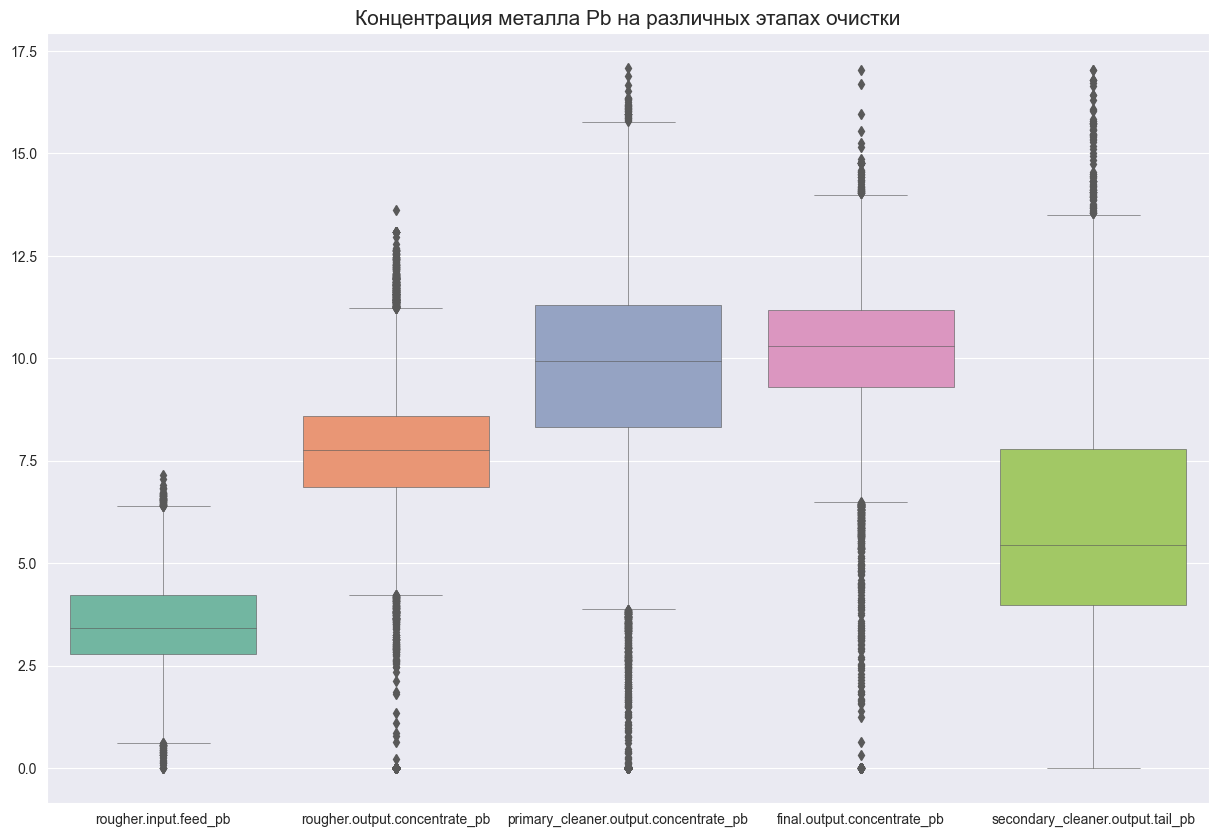

In [28]:
boxplot(elements['свинец'])

Найдем и устраним редкие и выбивающиеся занчения проанализировав через метод .describe() по аналогии с тем, как это реализовано в диаграмме размаха.

In [29]:
data_train1 = data_train#data_train1 обучающий без обработки
# функция для подсчёта границ с учетом 1.5 размаха
def quartile_range(data, column):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    dfq = data.loc[(data[column] < q3 + 1.5*iqr) & (data[column] > q1 - 1.5*iqr), column]
    return dfq
list_features = ['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au', 'rougher.output.recovery',
       'rougher.output.tail_ag', 'rougher.output.tail_pb',
       'rougher.output.tail_sol', 'rougher.output.tail_au',
       'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level',
       'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level',
       'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_c_level',
       'rougher.state.floatbank10_d_air', 'rougher.state.floatbank10_d_level',
       'rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_e_level',
       'rougher.state.floatbank10_f_air', 'rougher.state.floatbank10_f_level',
       'secondary_cleaner.output.tail_ag', 'secondary_cleaner.output.tail_pb',
       'secondary_cleaner.output.tail_sol', 'secondary_cleaner.output.tail_au',
       'secondary_cleaner.state.floatbank2_a_air',
       'secondary_cleaner.state.floatbank2_a_level',
       'secondary_cleaner.state.floatbank2_b_air',
       'secondary_cleaner.state.floatbank2_b_level',
       'secondary_cleaner.state.floatbank3_a_air',
       'secondary_cleaner.state.floatbank3_a_level',
       'secondary_cleaner.state.floatbank3_b_air',
       'secondary_cleaner.state.floatbank3_b_level',
       'secondary_cleaner.state.floatbank4_a_air',
       'secondary_cleaner.state.floatbank4_a_level',
       'secondary_cleaner.state.floatbank4_b_air',
       'secondary_cleaner.state.floatbank4_b_level',
       'secondary_cleaner.state.floatbank5_a_air',
       'secondary_cleaner.state.floatbank5_a_level',
       'secondary_cleaner.state.floatbank5_b_air',
       'secondary_cleaner.state.floatbank5_b_level',
       'secondary_cleaner.state.floatbank6_a_air',
       'secondary_cleaner.state.floatbank6_a_level']# столбцы с выбросами
for col in list_features:
    data_train[col] = quartile_range(data_train, col)

### Проверим пропуски

In [30]:
data_train.isna().mean().sort_values(ascending=False)

secondary_cleaner.state.floatbank4_a_level    0.279949
secondary_cleaner.state.floatbank5_a_level    0.273730
primary_cleaner.state.floatbank8_d_level      0.262916
primary_cleaner.state.floatbank8_c_level      0.230546
secondary_cleaner.state.floatbank3_b_level    0.227507
                                                ...   
rougher.state.floatbank10_d_level             0.000071
secondary_cleaner.state.floatbank4_b_air      0.000071
rougher.state.floatbank10_a_level             0.000071
rougher.state.floatbank10_c_level             0.000071
rougher.state.floatbank10_e_level             0.000000
Length: 86, dtype: float64

In [31]:
data_train[['rougher.output.recovery', 'final.output.recovery']].isna().mean().sort_values(ascending=False)

final.output.recovery      0.050322
rougher.output.recovery    0.040568
dtype: float64

Данные в пропуске с целевым признаком удалим, чтоб они неискажали нашу модель(5% и 4% от всех данных). Остальные пропуски заменим на методом ffill

In [32]:
data_train[['rougher.output.recovery', 'final.output.recovery']] = (data_train[['rougher.output.recovery', 'final.output.recovery']] != data_train[['rougher.output.recovery', 'final.output.recovery']].isna())

In [33]:
data_train[['rougher.output.recovery', 'final.output.recovery']].isna().mean().sort_values(ascending=False)

rougher.output.recovery    0.0
final.output.recovery      0.0
dtype: float64

In [34]:
data_train = data_train.ffill()

In [35]:
data_train.isna().mean().sort_values(ascending=False)

secondary_cleaner.state.floatbank6_a_level       0.021839
rougher.state.floatbank10_f_air                  0.000424
final.output.tail_sol                            0.000141
primary_cleaner.state.floatbank8_d_level         0.000071
secondary_cleaner.state.floatbank2_a_level       0.000071
                                                   ...   
rougher.calculation.sulfate_to_au_concentrate    0.000000
primary_cleaner.state.floatbank8_d_air           0.000000
primary_cleaner.state.floatbank8_c_level         0.000000
primary_cleaner.state.floatbank8_c_air           0.000000
rougher.output.concentrate_ag                    0.000000
Length: 86, dtype: float64

### Проверим дубликаты

In [36]:
data_full.duplicated().sum()

0

In [37]:
data_test.duplicated().sum()

0

In [38]:
data_train.duplicated().sum()

0

### Вывод 

1. У нас имеется три датасета:  
- data_full -первоначальный сет  
- data_train - сет для обучения модели(27,21% от full) обработали пропуски и аномалии (data_train1 без обработки)
- data_test - сет для теста(72,79% от full)
2. Оба целевых признака отсутствовали в тестовой выборке, взяли их из полной выборке. За индексы использовали дату со временем.
3. Многие праметры связаны между собой, следовательно пока не будем удалять столбцы. Потом это можно будет сделать. когда мы будем уверенны, что удаление параметров не повлияет на модель.
4. Нашли и устраним редкие и выбивающиеся занчения проанализировав через метод .describe() по аналогии с тем, как это реализовано в диаграмме размаха.
5. Данные с пропусками в целевых признаков удалили(5% от всех данных), чтоб они не оказали влияние на модель
6. Остальные пропуски в данных обработали с помощью метода ffil
7. Исходя из технологической схемы, нам необходимо будет разделить обучающую выборку на два компонента - это флотации и два этапа очистки
8. Формула для вычисления эффективности обогощении верна.

## Анализ данных

### Разделение обучающей выборки по процессам


Приведем признаки train к test, выделим сет процесса rougher

In [39]:
X_train = data_train[data_test.columns]

rougher_cols = X_train.columns.str.contains('rougher')
X_train_rougher = X_train.loc[:, rougher_cols]
X_test_rougher = data_test.loc[:, rougher_cols]
y_train_rougher = data_train[['rougher.output.recovery']]
X_train_rougher.columns


Index(['rougher.input.feed_ag', 'rougher.input.feed_pb',
       'rougher.input.feed_rate', 'rougher.input.feed_size',
       'rougher.input.feed_sol', 'rougher.input.feed_au',
       'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
       'rougher.state.floatbank10_f_level', 'rougher.output.recovery'],
      dtype='object')

In [40]:
X_train_rougher.shape, y_train_rougher.shape, X_test_rougher.shape


((14149, 23), (14149, 1), (5290, 23))

Аналогично сделаем для этапа final, состоящий из двух этапов очистки cleaner

In [41]:
final_cols = X_train.columns.str.contains('cleaner')
X_train_final = X_train.loc[:, final_cols]
X_test_final = data_test.loc[:, final_cols]
y_train_final = data_train[['final.output.recovery']]
X_train_final.columns

Index(['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level',
       'secondary_cleaner.state.floatbank2_a_air',
       'secondary_cleaner.state.floatbank2_a_level',
       'secondary_cleaner.state.floatbank2_b_air',
       'secondary_cleaner.state.floatbank2_b_level',
       'secondary_cleaner.state.floatbank3_a_air',
       'secondary_cleaner.state.floatbank3_a_level',
       'secondary_cleaner.state.floatbank3_b_air',
       'secondary_cleaner.state.floatbank3_b_level',
       'secondary_cleaner.state.

In [42]:

X_train_final.shape, y_train_final.shape, X_test_final.shape

((14149, 30), (14149, 1), (5290, 30))

Таким образом мы имеем две выборки для обучения - одна для флотации и другая для очистки

### Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишим выводы.

In [43]:
def fraction(elem):
    
    cols = ['rougher.input.feed_'+elem, 'rougher.output.concentrate_'+elem, 
            'primary_cleaner.output.concentrate_'+elem, 'secondary_cleaner.output.tail_'+elem,
            'final.output.concentrate_'+elem]
    fig_dims = (5, 5)
    fig1, ax1 = plt.subplots(figsize=fig_dims) 
    plt.legend([str(elem).title()])
    sns.kdeplot(data_train[cols], shade=True, alpha=.42, ax=ax1)
    plt.title('График плотности концентрация металла ' + str(elem).title() + ' на различных этапах очистки', fontsize=15)
    plt.xlabel('Концентрация металла ' + str(elem).title() + ' на различных этапах очистки')
    plt.ylabel('Плотность')
    plt.show()

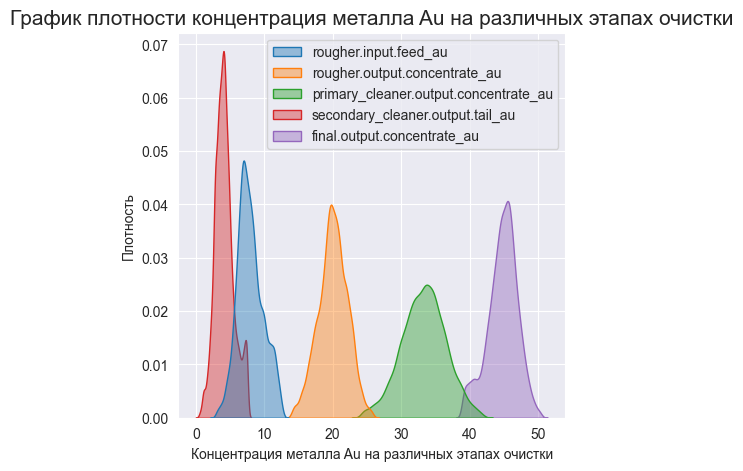

In [44]:
fraction(elements['золото'])

Выводы по концентрации золота на различных этпах очистки:
1. Меньше всего концентрации золота после вторичной очистки в отвальных хвостах. Это очень хорошо, чем их меньше, тем лучше происходит технологический процесс очистки. В идеале этот показатель будет стремиться к нулю.
2. Этап флотации (rougher) концентрация на выходе больше чем на входе. Что тоже логично.
3. Первичная очистка еще значительно увеличивает концентрацию золота в продукте.
4. В финальном продукте(после вторичной очистки и отделения хвостов) самая большая концентрация золота.

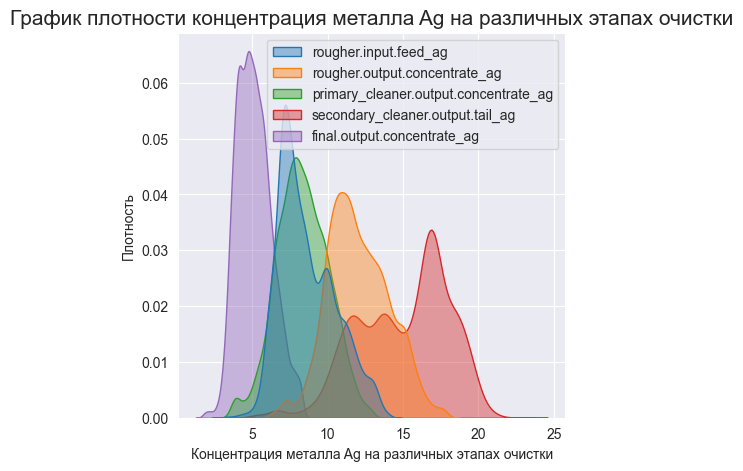

In [45]:
fraction(elements['серебро'])

Выводы по концентрации серебка на различных этпах очистки:
1. Меньше всего концентрации серебра после вторичной очистки в выходе продукта. 
2. Этап флотации на входе (rougher) и первичной очистки концентрация серебра в продукте почти одинаков
3. После флотации больше всего концентрации серебкра, за исключением отвальных хвостов.

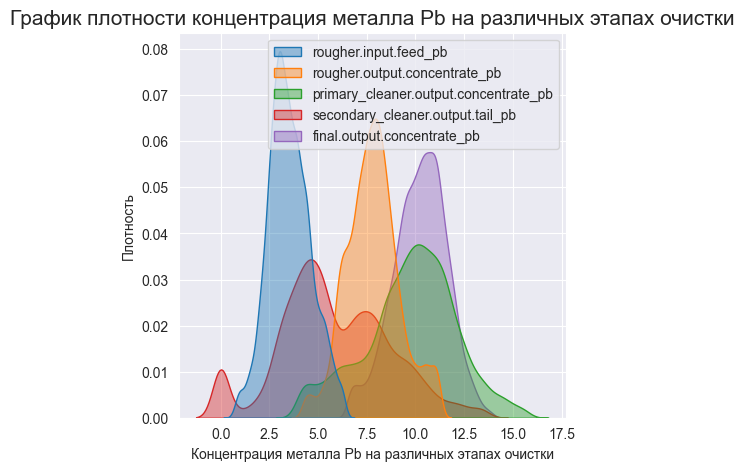

In [46]:
fraction(elements['свинец'])

Выводы по концентрации сввинца на различных этпах очистки:
1. На выходе продукта довольно значительные концентрация свинца как и при первичной очистки
2. В отвалах хвостах и на входе на флотацию концентрация мала.
3. Можно сделать вывод, что в ходе процесса концентрация свинца только увеличивается. Либо в роцессе совсем не предусмотренна очистка от днного металла

### Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

Проверка гипотезы:  распределения размеров гранул сырья на обучающей и тестовой выборках различаются;  

```
H_0:  распределения размеров гранул сырья на обучающей и тестовой выборках равны  
H_a:  распределения размеров гранул сырья на обучающей и тестовой выборках не равны  
alpha = 0.05
```

In [63]:
# Plot the histograms
def granule_size_distribution(stage):
    plt.hist(data_test[stage+'.input.feed_size'], alpha=0.5, label='Test Data',bins=100,)
    plt.hist(data_train[stage+'.input.feed_size'], alpha=0.5, label='Train Data',bins=100)
    plt.title('Распределения размеров зерен в тестовой выборке и обучающей (сырье) '+stage)
    plt.legend()
    plt.show()

    results = st.ttest_ind(
        data_train[stage+'.input.feed_size'], 
        data_test[stage+'.input.feed_size'], equal_var = False)
    alpha = .05 # alpha = задайте значение уровня значимости

    if results.pvalue < alpha:
        print("Отвергаем нулевую гипотезу, размер гранул различаются(p = {})".format(results.pvalue))
    else:
        print("Не получилось отвергнуть нулевую гипотезу, размер гранул не различаются(p = {})".format(results.pvalue))


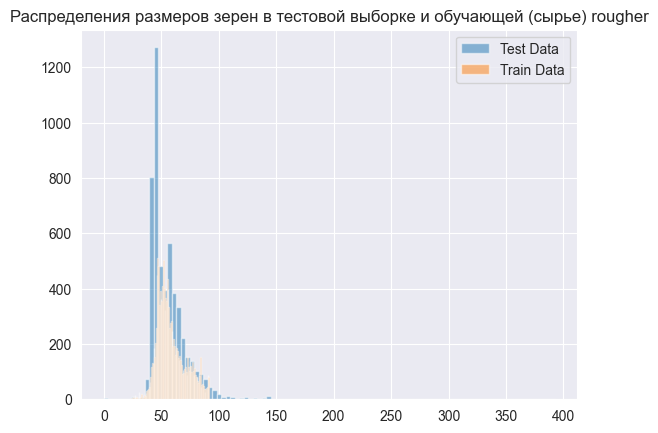

Не получилось отвергнуть нулевую гипотезу, размер гранул не различаются(p = nan)


In [64]:
granule_size_distribution('rougher')

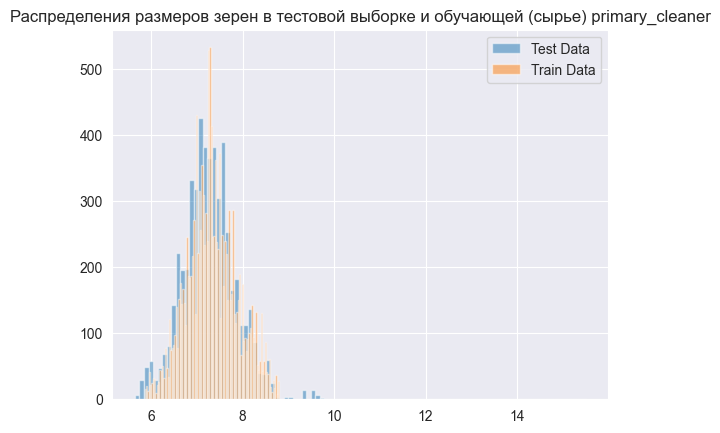

Отвергаем нулевую гипотезу, размер гранул различаются(p = 2.8304456764529202e-11)


In [65]:
granule_size_distribution('primary_cleaner')

Размер гранул по графикам не сильно различаються. И интересней нам больше размер гранул постпающие на флотацию. Хотя и желательно в дальнейшем брать более точные выборки

### Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 

## Модель

### Напишите функцию для вычисления итоговой sMAPE.

**Метрика качества**
Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).  
Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных. Почему симметричная? Она одинаково учитывает масштаб и целевого признака, и предсказания.  
Метрика sMAPE вычисляется так:  

${\large sMAPE = \dfrac{1}{N}{\displaystyle\sum_{i=1}^N} \dfrac{|y_i - \hat{y_i}|}{(|y_i| - |\hat{y_i}|)/2}100\%}$

Обозначения:  
${\large {y_i}}$ - Значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество.  
${\large \hat{y_i}}$ - Значение предсказания для объекта с порядковым номером i, например, в тестовой выборке.  
${\large {N}}$ - Количество объектов в выборке.
${\large {\displaystyle\sum_{i=1}^N} }$ - Суммирование по всем объектам выборки (i меняется от 1 до N).  

Итоговая метрика складывается из двух величин: 
<img src="https://pictures.s3.yandex.net/resources/_smape_1576238814.jpg"/> 

### Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке выполнения
- [x]  Выполнен шаг 1: данные подготовлены
    - [x]  Проверена формула вычисления эффективности обогащения
    - [x]  Проанализированы признаки, недоступные в тестовой выборке
    - [x]  Проведена предобработка данных
- [ ]  Выполнен шаг 2: данные проанализированы
    - [ ]  Исследовано изменение концентрации элементов на каждом этапе
    - [ ]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [ ]  Исследованы суммарные концентрации
- [ ]  Выполнен шаг 3: построена модель прогнозирования
    - [ ]  Написана функция для вычисления итогового *sMAPE*
    - [ ]  Обучено и проверено несколько моделей
    - [ ]  Выбрана лучшая модель, её качество проверено на тестовой выборке